In [ ]:
pip install opencv-python opencv-python-headless

In [ ]:
import pandas as pd
import cv2
import os
import requests
from tempfile import NamedTemporaryFile

# Load the dataset
input_file = r"/content/Assignment_Data.xlsx"
video_data = pd.read_excel(input_file)

# Directory for temporary video storage
temp_video_dir = "temporary_videos"
os.makedirs(temp_video_dir, exist_ok=True)

# Load the pre-trained DNN face detector
model_file = r"/content/res10_300x300_ssd_iter_140000.caffemodel"
config_file = r"/content/deploy.prototxt"
face_detector = cv2.dnn.readNetFromCaffe(config_file, model_file)

# Function to download a video
def download_video_from_url(video_url):
    response = requests.get(video_url, stream=True)
    if response.status_code == 200:
        temp_file = NamedTemporaryFile(delete=False, suffix=".mp4", dir=temp_video_dir)
        with open(temp_file.name, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        return temp_file.name
    return None

# Function to determine if a human face is detected in a video
def detect_face_in_video(video_file):
    video_capture = cv2.VideoCapture(video_file)
    face_found = False

    while video_capture.isOpened():
        ret, frame = video_capture.read()
        if not ret:
            break

        # Prepare the frame for face detection
        (frame_height, frame_width) = frame.shape[:2]
        input_blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        face_detector.setInput(input_blob)
        detections = face_detector.forward()

        # Check if any detections indicate a face
        for i in range(0, detections.shape[2]):
            detection_confidence = detections[0, 0, i, 2]
            if detection_confidence > 0.5:  # Confidence threshold
                # Extract face bounding box
                box_coordinates = detections[0, 0, i, 3:7] * [frame_width, frame_height, frame_width, frame_height]
                (x1, y1, x2, y2) = box_coordinates.astype("int")
                face_found = True
                break
        if face_found:
            break

    video_capture.release()
    return face_found

# Process each video to filter those with detected faces
valid_videos = []
for idx, video_row in video_data.iterrows():
    print(f"Processing video {idx + 1}/{len(video_data)}...")
    video_url = video_row['Video URL']
    video_file_path = download_video_from_url(video_url)
    if video_file_path:
        if detect_face_in_video(video_file_path):
            valid_videos.append(idx)
        os.remove(video_file_path)

# Generate the filtered dataset
filtered_videos_data = video_data.iloc[valid_videos]

# Save the filtered dataset to an Excel file
output_file = 'filtered_data.xlsx'
filtered_videos_data.to_excel(output_file, index=False)
print(f"Filtered dataset saved to '{output_file}'")


Processing video 1/268...
Processing video 2/268...
Processing video 3/268...
Processing video 4/268...
Processing video 5/268...
Processing video 6/268...
Processing video 7/268...
Processing video 8/268...
Processing video 9/268...
Processing video 10/268...
Processing video 11/268...
Processing video 12/268...
Processing video 13/268...
Processing video 14/268...
Processing video 15/268...
Processing video 16/268...
Processing video 17/268...
Processing video 18/268...
Processing video 19/268...
Processing video 20/268...
Processing video 21/268...
Processing video 22/268...
Processing video 23/268...
Processing video 24/268...
Processing video 25/268...
Processing video 26/268...
Processing video 27/268...
Processing video 28/268...
Processing video 29/268...
Processing video 30/268...
Processing video 31/268...
Processing video 32/268...
Processing video 33/268...
Processing video 34/268...
Processing video 35/268...
Processing video 36/268...
Processing video 37/268...
Processing

In [ ]:
pip install pandas opencv-python face_recognition requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=c54b43fc0932c05bb668200e30404ef230a0cf4417eb6a67b7fa38ce154b5b70
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import pandas as pd
import cv2
import face_recognition
import os
import base64
from tempfile import NamedTemporaryFile
import requests
import numpy as np

# Load the input Excel file containing video URLs and performance values
input_file = r"/content/filtered_data.xlsx"  # Update this with your file path
video_data = pd.read_excel(input_file)

# Create directories for temporary videos and unique faces
temp_video_storage = "temp_videos1"
unique_face_storage = "unique_faces"
os.makedirs(temp_video_storage, exist_ok=True)
os.makedirs(unique_face_storage, exist_ok=True)

# Function to download video from URL
def fetch_video(url):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        temp_file = NamedTemporaryFile(delete=False, suffix=".mp4", dir=temp_video_storage)
        with open(temp_file.name, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        return temp_file.name
    return None

# Function to measure the clarity of an image
def compute_sharpness(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray_image, cv2.CV_64F).var()

# Step 1: Process each video to extract unique faces
extracted_faces = []  # Collect face details from all videos

for idx, row in video_data.iterrows():
    print(f"Processing video {idx + 1}/{len(video_data)}...")
    video_url = row['Video URL']
    performance_score = row['Performance']
    video_file_path = fetch_video(video_url)

    if video_file_path:
        try:
            cap = cv2.VideoCapture(video_file_path)
            face_encodings_in_video = []
            face_images_in_video = []
            sharpness_scores = []

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Convert the frame to RGB format for face detection
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                detected_faces = face_recognition.face_locations(rgb_frame)
                encodings = face_recognition.face_encodings(rgb_frame, detected_faces)

                for face_encoding, face_location in zip(encodings, detected_faces):
                    is_duplicate = False
                    for known_face in face_encodings_in_video:
                        if face_recognition.compare_faces([known_face], face_encoding, tolerance=0.6)[0]:
                            is_duplicate = True
                            break

                    if not is_duplicate:
                        # Save details for this unique face
                        face_encodings_in_video.append(face_encoding)
                        top, right, bottom, left = face_location
                        cropped_face = frame[top:bottom, left:right]
                        face_images_in_video.append(cropped_face)
                        sharpness_scores.append(compute_sharpness(cropped_face))

            cap.release()
            os.remove(video_file_path)

            # Save video-specific face data
            for encoding, image, sharpness in zip(face_encodings_in_video, face_images_in_video, sharpness_scores):
                extracted_faces.append({
                    'encoding': encoding,
                    'image': image,
                    'sharpness': sharpness,
                    'performance': performance_score
                })

        except Exception as e:
            print(f"Error processing video {video_url}: {e}")
            continue

# Step 2: Group similar faces across all videos
distinct_faces = []
face_groups = []

for face in extracted_faces:
    is_grouped = False
    for i, existing_face in enumerate(distinct_faces):
        if face_recognition.compare_faces([existing_face], face['encoding'], tolerance=0.6)[0]:
            # Add details to the existing group
            face_groups[i]['scores'].append(face['performance'])
            face_groups[i]['images'].append(face['image'])
            face_groups[i]['sharpness'].append(face['sharpness'])
            is_grouped = True
            break

    if not is_grouped:
        # Create a new group for this unique face
        distinct_faces.append(face['encoding'])
        face_groups.append({
            'scores': [face['performance']],
            'images': [face['image']],
            'sharpness': [face['sharpness']]
        })

# Step 3: Select the best photo and calculate average performance for each face group
final_face_data = []

for idx, group in enumerate(face_groups):
    avg_performance = np.mean(group['scores'])
    clearest_image_idx = np.argmax(group['sharpness'])
    clearest_image = group['images'][clearest_image_idx]
    face_image_path = os.path.join(unique_face_storage, f"face_{idx + 1}.jpg")
    cv2.imwrite(face_image_path, clearest_image)
    final_face_data.append({
        'Face Index': idx + 1,
        'Face Image Path': face_image_path,
        'Average Performance': avg_performance
    })

# Step 4: Create a DataFrame for final results
final_results_df = pd.DataFrame(final_face_data)

# Step 5: Generate an HTML table with embedded face images
def generate_html_table(data, output_file):
    def encode_image_to_base64(image_path):
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode('utf-8')

    html = "<html><head><title>Unique Faces and Performance</title></head><body>"
    html += "<table border='1' style='border-collapse: collapse;'>"
    html += "<tr><th>Face</th><th>Average Performance</th></tr>"

    for _, row in data.iterrows():
        img_path = row['Face Image Path']
        avg_perf = row['Average Performance']
        img_base64 = encode_image_to_base64(img_path)
        html += f"<tr><td><img src='data:image/jpeg;base64,{img_base64}' width='100'></td><td>{avg_perf}</td></tr>"

    html += "</table></body></html>"

    with open(output_file, 'w') as f:
        f.write(html)

# Save the results to files
final_results_df.to_excel('unique_faces_performance.xlsx', index=False)
generate_html_table(final_results_df, 'unique_faces_table.html')

print("Results saved as 'unique_faces_performance.xlsx' and 'unique_faces_table.html'.")


Processing video 1/244...
Processing video 2/244...
Processing video 3/244...
Processing video 4/244...
Processing video 5/244...
Processing video 6/244...
Processing video 7/244...
Processing video 8/244...
Processing video 9/244...
Processing video 10/244...
Processing video 11/244...
Processing video 12/244...
Processing video 13/244...
Processing video 14/244...
Processing video 15/244...
Processing video 16/244...
Processing video 17/244...
Processing video 18/244...
Processing video 19/244...
Processing video 20/244...
Processing video 21/244...
Processing video 22/244...
Processing video 23/244...
Processing video 24/244...
Processing video 25/244...
Processing video 26/244...
Processing video 27/244...
Processing video 28/244...
Processing video 29/244...
Processing video 30/244...
Processing video 31/244...
Processing video 32/244...
Processing video 33/244...
Processing video 34/244...
Processing video 35/244...
Processing video 36/244...
Processing video 37/244...
Processing

In [ ]:
from google.colab import files
files.download('unique_faces_table.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil

# Replace 'folder_name' with the path to your folder
shutil.make_archive('unique_faces', 'zip', 'unique_faces')


'/content/unique_faces.zip'

In [ ]:
from google.colab import files

# Download the zip file
files.download('unique_faces.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from bs4 import BeautifulSoup
import pandas as pd

# Function to arrange an HTML table in descending order based on a specific column
def reorder_html_table(input_html, output_html, column_to_sort):
    # Load and parse the HTML file using BeautifulSoup
    with open(input_html, 'r') as file:
        soup = BeautifulSoup(file, 'html.parser')

    # Locate the table and extract its headers and rows
    table = soup.find('table')
    headers = [header.get_text() for header in table.find('tr').find_all('th')]
    rows = table.find_all('tr')[1:]  # Exclude the header row

    # Convert table rows into a DataFrame
    data_entries = []
    for row in rows:
        columns = row.find_all('td')
        img_element = columns[0].find('img')  # Get the image tag
        img_source = img_element['src'] if img_element else None  # Extract image source
        performance_value = float(columns[1].get_text())  # Extract the performance value
        data_entries.append([img_source, performance_value])

    # Create a pandas DataFrame with the extracted data
    df = pd.DataFrame(data_entries, columns=headers)

    # Sort the DataFrame in descending order by the specified column
    df = df.sort_values(by=column_to_sort, ascending=False)

    # Build a new HTML table using the sorted data
    html_output = "<html><head><title>Reordered Table</title></head><body>"
    html_output += "<table border='1' style='border-collapse: collapse;'>"
    html_output += "<tr><th>Face</th><th>Average Performance</th></tr>"

    for _, row in df.iterrows():
        img_source = row['Face']
        performance = row['Average Performance']
        html_output += f"<tr><td><img src='{img_source}' width='100'></td><td>{performance}</td></tr>"

    html_output += "</table></body></html>"

    # Write the updated table to a new HTML file
    with open(output_html, 'w') as file:
        file.write(html_output)

    print(f"Reordered HTML table has been saved to '{output_html}'.")

# Define input and output HTML file paths
input_html = 'unique_faces_table.html'  # Path to the original HTML file
output_html = 'reordered_faces_table.html'  # Path for the new reordered HTML file
column_to_sort = 'Average Performance'  # Column to sort by

# Call the function to reorder the HTML table
reorder_html_table(input_html, output_html, column_to_sort)


Reordered HTML table has been saved to 'reordered_faces_table.html'.


In [21]:
from google.colab import files
files.download('reordered_faces_table.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from bs4 import BeautifulSoup

# Function to style an HTML table with enhanced visual appeal and border formatting
def style_html_table_with_borders(input_html, output_html, styles, winner_index=0):
    # Read the HTML file
    with open(input_html, 'r') as f:
        soup = BeautifulSoup(f, 'html.parser')

    # Update the "Face" heading to "Unique Influencers"
    table = soup.find("table")
    if table:
        headers = table.find_all("th")
        if len(headers) > 0:
            headers[0].string = "Unique Influencers"
            headers[0]['style'] = f"font-weight: bold; text-decoration: underline; color: {styles['header_text_color']};"

        # Format all headers with a bottom border
        for header in headers:
            header['style'] = f"border-bottom: 3px solid {styles['header_border_color']}; padding: 12px;"

    # Add the winner emoji near the first influencer's average performance value
    if table:
        rows = table.find_all("tr")[1:]  # Skip the header row
        if len(rows) > winner_index:
            columns = rows[winner_index].find_all("td")
            if len(columns) > 1:  # Assuming average performance is in the second column
                columns[1].string = f"{columns[1].string} 🏆"

    # Add custom styles to the HTML
    style_tag = soup.new_tag("style")
    style_tag.string = f"""
    body {{
        font-family: {styles['font_family']};
        background-color: {styles['body_bg_color']};
        margin: 20px;
    }}
    table {{
        width: {styles['table_width']};
        border-collapse: separate;
        border-spacing: 0;
        margin: 20px auto;
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
        border-radius: 10px;
        overflow: hidden;
        border: 2px solid {styles['table_border_color']};
    }}
    th, td {{
        padding: 12px 15px;
        text-align: center;
        border: 1px solid {styles['cell_border_color']};
    }}
    th {{
        background-color: {styles['header_bg_color']};
        color: {styles['header_text_color']};
        font-size: {styles['header_font_size']};
        font-weight: bold;
        border-top: 2px solid {styles['header_border_color']};
    }}
    td {{
        font-size: {styles['cell_font_size']};
        color: {styles['cell_text_color']};
    }}
    tr:nth-child(even) {{
        background-color: {styles['row_even_bg_color']};
    }}
    tr:nth-child(odd) {{
        background-color: {styles['row_odd_bg_color']};
    }}
    tr:hover {{
        background-color: {styles['row_hover_bg_color']};
        cursor: pointer;
    }}
    img {{
        max-width: {styles['image_width']};
        max-height: {styles['image_height']};
        border-radius: 5px;
    }}
    """
    soup.head.insert(0, style_tag)

    # Save the styled HTML table
    with open(output_html, 'w') as f:
        f.write(str(soup))

    print(f"Styled HTML table saved as '{output_html}'.")

# Specify input and output HTML files
input_html = 'reordered_faces_table.html'  # Replace with your input HTML file
output_html = 'styled_faces_table_enhanced.html'  # Path for the output styled HTML file

# Define enhanced styles for the table with border formatting
styles = {
    'font_family': 'Arial, sans-serif',
    'body_bg_color': '#f9f9f9',
    'table_width': '80%',
    'table_border_color': '#444',
    'header_bg_color': '#3f51b5',
    'header_text_color': 'white',
    'header_font_size': '20px',
    'header_border_color': '#ffffff',
    'cell_font_size': '16px',
    'cell_text_color': '#555',
    'cell_border_color': '#ddd',
    'row_even_bg_color': '#f2f2f2',
    'row_odd_bg_color': '#ffffff',
    'row_hover_bg_color': '#d1e7fd',
    'image_width': '120px',
    'image_height': '120px',
}

# Style the HTML table with enhanced border visuals
style_html_table_with_borders(input_html, output_html, styles)


Styled HTML table saved as 'styled_faces_table_enhanced.html'.


In [25]:
from google.colab import files
files.download('styled_faces_table_enhanced.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Unique Influencers,Average Performance
,1.6774006584999999 🏆
,1.3391358337625001
,1.2417320009
,1.1484264983499999
,1.1476679516666666
,1.1437682221071428
,1.06452448145
,1.0546459828827275
,1.0364740071249998
,1.0364581079081054

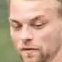
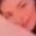
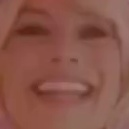
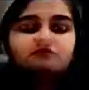
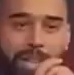
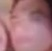
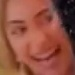
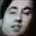
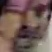
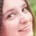
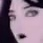
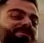
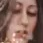
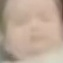
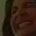
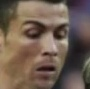
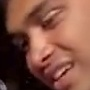
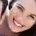
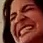
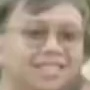
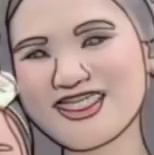
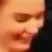
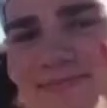
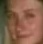
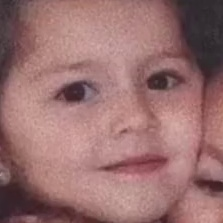
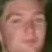
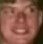
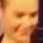
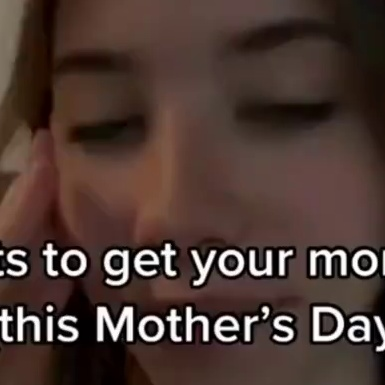
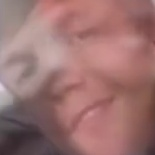

In [24]:
from IPython.core.display import display, HTML

with open('styled_faces_table_enhanced.html', 'r') as f:
    html_content = f.read()

display(HTML(html_content))